In [1]:
%matplotlib notebook

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import os
import pickle
import sys
sys.path.append("../benchmark/")

## Old Higgs Trajectories

In [9]:
folder = "../benchmark/logs/"
files_higgs = [
    "ho_higgs_coarse_10000.json",
    "ho_higgs_coarse_7500.json",
    "ho_higgs_coarse_5000.json",
]

In [5]:
data_higgs = []
for fn in files_higgs:
    with open(os.path.join(folder, fn), "r") as fh:
        data_higgs.append(json.load(fh))

In [6]:
def plot_hp(data):
    fig, ax = plt.subplots()
    num_iter = len(data['ho'])
    num_hos = len(data['ho'][0]['hparams'])
    time_range = [data['ho'][i]['time'] for i in range(num_iter)]
    
    for h in range(num_hos):
        ax.plot(time_range, [data['ho'][i]['hparams'][h] for i in range(num_iter)])
    ax.set_ylabel("Hyper-parameter values")
    ax.set_xlabel("Time (s)")

    ax2 = ax.twinx()
    ax2.plot(time_range, [data['ho'][i]['val_loss'] for i in range(num_iter)], lw=2, c="k",
             label="Validation loss")
    ax2.plot(time_range[1:], [data['partial_test_errors']['AUC'][i] for i in range(num_iter - 1)],
             lw=2, c='r', linestyle='--', label="Test AUC")
    
    ax2.scatter(time_range[-1], data_higgs[0][-1]['retrain_test_errors']['AUC'], s=90, label="Retrain test AUC")
    
    ax2.legend(loc="best")
    ax2.set_ylabel("Validation loss")
    

<IPython.core.display.Javascript object>


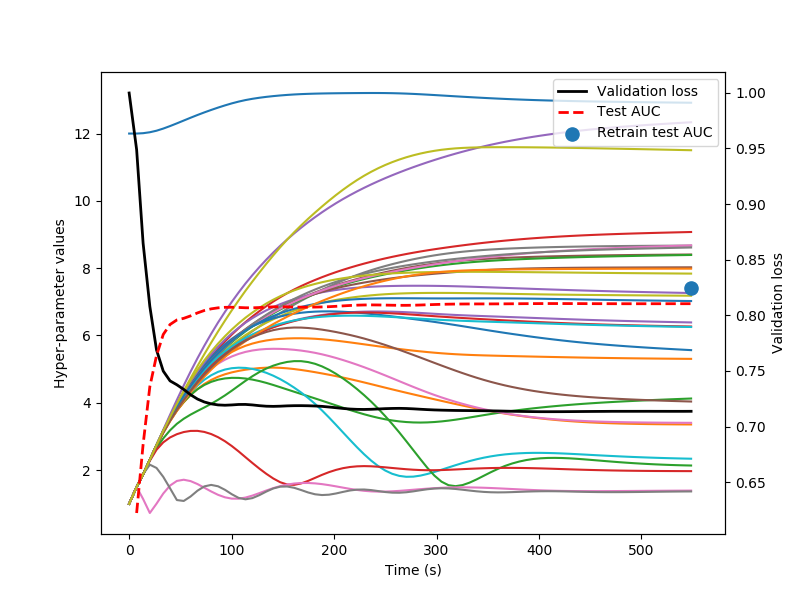

In [64]:
plot_hp(data_higgs[0][-1])

In [8]:
with open(os.path.join(folder, "hotraj_ho-higgs_1607960088133.csv"), "r") as fh:
    traj_data = json.load(fh)
# plot_hp(data_higgs[0][-1])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## Grid search on Different Objectives

In [77]:
ename = "test_tuned_m20"
data_loc = {
    "gcv": f"../benchmark/logs/boston_gs_gcv_{ename}.pkl",
    "loocv": f"../benchmark/logs/boston_gs_loocv_{ename}.pkl",
    "sgpr": f"../benchmark/logs/boston_gs_sgpr_{ename}.pkl",
    "hgrad-closed": f"../benchmark/logs/boston_gs_hgrad-closed_{ename}.pkl",
    "hgrad-ift": f"../benchmark/logs/boston_gs_hgrad-ift_{ename}.pkl",
}
dict_loc = {}
for k, v in data_loc.items():
    with open(v, 'rb') as fh:
        dict_loc[k] = pickle.load(fh)

In [60]:
dict_loc['sgpr']

[HPGridPoint(attributes={'Index': 0, 'sigma': 1.0, 'penalty': 1e-08}, results={'loss_log-det': tensor(-2788.9276, dtype=torch.float64), 'loss_data-fit': tensor(5.3588e+11, dtype=torch.float64), 'loss_trace': tensor(9.0326e+09), 'loss_const': tensor(371.2512, dtype=torch.float64), 'loss': tensor(5.4492e+11, dtype=torch.float64), 'cum_time': 0.06590437889099121, 'train_NRMSE': 1.4714855074708968, 'test_NRMSE': 1.8623893144439807}),
 HPGridPoint(attributes={'Index': 1, 'sigma': 1.0, 'penalty': 4.39397056e-08}, results={'loss_log-det': tensor(-2563.9320, dtype=torch.float64), 'loss_data-fit': tensor(1.2196e+11, dtype=torch.float64), 'loss_trace': tensor(2.0557e+09), 'loss_const': tensor(371.2512, dtype=torch.float64), 'loss': tensor(1.2401e+11, dtype=torch.float64), 'cum_time': 0.07109737396240234, 'train_NRMSE': 1.4714855074709006, 'test_NRMSE': 1.8623893283482722}),
 HPGridPoint(attributes={'Index': 2, 'sigma': 1.0, 'penalty': 1.93069773e-07}, results={'loss_log-det': tensor(-2338.9368, 

<IPython.core.display.Javascript object>


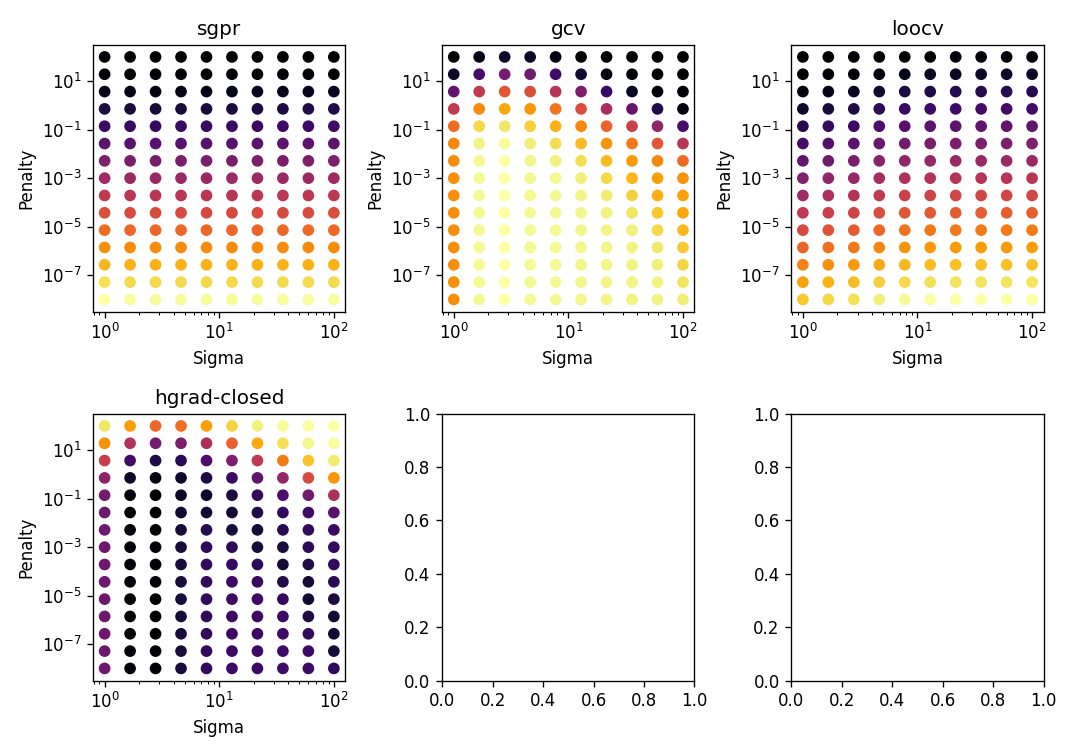

In [78]:
def get_clims(dict_loc):
    cmin, cmax = 1e99, -1e99
    for v in dict_loc.values():
        if 'loss' not in v[0].results:
            continue
        cmin = min(cmin, min([el.results['loss'] for el in v]))
        cmax = max(cmax, max([el.results['loss'] for el in v]))
    return cmin, cmax
        

def do_plot(obj_name, dict_loc, ax, **kwargs):
    do_log = obj_name in {'sgpr', 'loocv'}
    cdict = dict_loc[obj_name]
    sigmas = [el.attributes['sigma'] for el in cdict]
    penalties = [el.attributes['penalty'] for el in cdict]
    loss = [el.results['loss'] for el in cdict]
    if do_log:
        loss = np.log(loss)
    ax.scatter(sigmas, penalties, c=loss, **kwargs)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Sigma")
    ax.set_ylabel("Penalty")
    ax.set_title(obj_name)
    
vmin, vmax = get_clims(dict_loc)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6.3))
ax = ax.flatten()
for i, obj_name in enumerate(['sgpr', 'gcv', 'loocv', 'hgrad-closed']):
    do_plot(obj_name, dict_loc, ax[i], cmap='inferno')
fig.tight_layout()

In [51]:
loss

[tensor(-5.3588e+11, dtype=torch.float64),
 tensor(-1.2196e+11, dtype=torch.float64),
 tensor(-2.7756e+10, dtype=torch.float64),
 tensor(-6.3168e+09, dtype=torch.float64),
 tensor(-1.4376e+09, dtype=torch.float64),
 tensor(-3.2718e+08, dtype=torch.float64),
 tensor(-74466434.6568, dtype=torch.float64),
 tensor(-16951752.6228, dtype=torch.float64),
 tensor(-3862293.3566, dtype=torch.float64),
 tensor(-883268.6312, dtype=torch.float64),
 tensor(-205037.6792, dtype=torch.float64),
 tensor(-49962.6128, dtype=torch.float64),
 tensor(-13428.9663, dtype=torch.float64),
 tensor(-3897.7674, dtype=torch.float64),
 tensor(-1115.9369, dtype=torch.float64),
 tensor(-4.3606e+11, dtype=torch.float64),
 tensor(-9.9239e+10, dtype=torch.float64),
 tensor(-2.2585e+10, dtype=torch.float64),
 tensor(-5.1401e+09, dtype=torch.float64),
 tensor(-1.1698e+09, dtype=torch.float64),
 tensor(-2.6624e+08, dtype=torch.float64),
 tensor(-60601140.6198, dtype=torch.float64),
 tensor(-13800667.6432, dtype=torch.float64